In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import tushare as ts

In [4]:
# 拉取数据
pro = ts.pro_api()
df_csi300 = pro.index_daily(**{
    "ts_code": "000300.SH",
    "trade_date": "",
    "start_date": 20200101,
    "end_date": 20251001,
    "limit": "",
    "offset": ""
}, fields=[
    "ts_code",
    "trade_date",
    "close",
    "open",
    "high",
    "low",
    "pre_close",
    "change",
    "pct_chg",
    "vol",
    "amount"
])

In [ ]:
try:
    df_csi = pro.index_weight(index_code='000300.SH', trade_date='20250930')

    # 3. 从返回的DataFrame中提取股票代码列表
    # 成分股代码在 'con_code' 这一列
    csi300_stock_list = df_csi['con_code'].tolist()

    print(f"成功获取到 {len(csi300_stock_list)} 只沪深300成分股。")
    print("部分成分股代码示例:")
    print(csi300_stock_list[:10])

except Exception as e:
    print(f"获取数据失败: {e}")

成功获取到 300 只沪深300成分股。
部分成分股代码示例:
['300750.SZ', '600519.SH', '601318.SH', '600036.SH', '601899.SH', '300502.SZ', '300308.SZ', '000333.SZ', '300059.SZ', '600900.SH']


In [9]:
all_stock_data = pd.read_csv('data/all_stock_data_20200101_20250922.csv')

In [10]:
all_stock_data['free_share']/all_stock_data['float_share']

0          0.686073
1          0.788235
2          0.647688
3          0.333619
4          0.426186
             ...   
6687291    0.726919
6687292    1.000000
6687293    0.805922
6687294    0.595411
6687295    0.432493
Length: 6687296, dtype: float64

In [9]:
all_stock_data['turnover_rate']/all_stock_data['turnover_rate_f']

0          0.686080
1          0.788227
2          0.647685
3          0.333621
4          0.426190
             ...   
6687291    0.726879
6687292    1.000000
6687293    0.805909
6687294    0.595422
6687295    0.432495
Length: 6687296, dtype: float64

In [17]:
np.min(all_stock_data['turnover_rate'])

0.0001

获取财务指标数据

In [10]:
# 获取所有股票的代码
all_stock_codes = all_stock_data['ts_code'].unique().tolist()

In [24]:
# 初始化pro接口
pro = ts.pro_api('3339f390298f8503dc5cbcca9fce9898f10bd3a5cb8ce9315803e5cd')

# 拉取数据


def get_financial_index(ts_code, start_date, end_date):

    # 拉取数据
    df = pro.fina_indicator(**{
        "ts_code": ts_code,
        "ann_date": "",
        "start_date": start_date,
        "end_date": end_date,
        "period": "",
        "update_flag": "",
        "limit": "",
        "offset": ""
    }, fields=[
        "ts_code",
        "ann_date",
        "end_date",
        "gross_margin",
        "current_ratio",
        "quick_ratio",
        "invturn_days",
        "arturn_days",
        "inv_turn",
        "ar_turn",
        "ca_turn",
        "fa_turn",
        "assets_turn",
        "interst_income",
        "daa",
        "ebit",
        "ebitda",
        "netprofit_margin",
        "grossprofit_margin",
        "cogs_of_sales",
        "ocf_to_or",
        "debt_to_assets",
        "q_sales_yoy",
        "q_profit_yoy",
        "update_flag"
    ])

    return df

In [26]:
# 拉取所有股票的数据
from tqdm import tqdm  # 1. 导入tqdm
import time
all_stock_financial_index = []
# 2. 将 all_stock_codes 用 tqdm() 包裹起来
for i in tqdm(all_stock_codes, desc="拉取财务数据"):
    try:
        df_financial = get_financial_index(i, '20200101', '20250929')
        if df_financial is not None and not df_financial.empty:
            all_stock_financial_index.append(df_financial)
    except Exception as e:
        print(f"\n处理股票 {i} 时发生错误: {e}")  # 打印错误信息，\n确保不被进度条覆盖
    time.sleep(0.2)

all_stock_financial_index_df = pd.concat(
    all_stock_financial_index, ignore_index=True)

print("所有股票数据拉取并合并完成！")
all_stock_financial_index_df.to_csv(
    'data/all_stock_financial_index_2020_2025.csv', index=False)
print("数据已保存")

拉取财务数据:  25%|██▌       | 1416/5634 [25:55<325:20:05, 277.67s/it]


处理股票 000920.SZ 时发生错误: HTTPConnectionPool(host='api.waditu.com', port=80): Max retries exceeded with url: /dataapi/fina_indicator (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x3034610a0>: Failed to resolve 'api.waditu.com' ([Errno 8] nodename nor servname provided, or not known)"))


拉取财务数据:  25%|██▌       | 1417/5634 [25:55<227:45:22, 194.43s/it]


处理股票 300019.SZ 时发生错误: HTTPConnectionPool(host='api.waditu.com', port=80): Max retries exceeded with url: /dataapi/fina_indicator (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x303461ca0>: Failed to resolve 'api.waditu.com' ([Errno 8] nodename nor servname provided, or not known)"))


拉取财务数据: 100%|██████████| 5634/5634 [57:52<00:00,  1.62it/s]     
/var/folders/46/3tft1dn53072_r6tdkcfpxsc0000gn/T/ipykernel_16016/4177137748.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_stock_financial_index_df = pd.concat(


所有股票数据拉取并合并完成！
数据已保存


In [28]:
df_mis1 = get_financial_index('000920.SZ', '20200101', '20250929')
df_mis2 = get_financial_index('300019.SZ', '20200101', '20250929')

In [64]:
# 拉取所有股票的数据
from tqdm import tqdm  # 1. 导入tqdm
import time
all_stock_financial_index = []
# 2. 将 all_stock_codes 用 tqdm() 包裹起来
for i in tqdm(all_stock_codes, desc="拉取财务数据"):
    try:
        df_financial = get_financial_index(i, '20190101', '20250930')
        if df_financial is not None and not df_financial.empty:
            all_stock_financial_index.append(df_financial)
    except Exception as e:
        print(f"\n处理股票 {i} 时发生错误: {e}")  # 打印错误信息，\n确保不被进度条覆盖
    time.sleep(0.2)

all_stock_financial_index_df = pd.concat(
    all_stock_financial_index, ignore_index=True)

print("所有股票数据拉取并合并完成！")
all_stock_financial_index_df.to_csv(
    'data/all_stock_financial_index_2019_2025.csv', index=False)
print("数据已保存")

拉取财务数据: 100%|██████████| 5634/5634 [42:12<00:00,  2.22it/s] 
/var/folders/46/3tft1dn53072_r6tdkcfpxsc0000gn/T/ipykernel_16016/205058404.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_stock_financial_index_df = pd.concat(


所有股票数据拉取并合并完成！
数据已保存


In [78]:
# 对数据的ann_date去重
financial_df = all_stock_financial_index_df.copy()

In [79]:
# === 第1步：预处理 ann_date 列 (保持不变) ===
financial_df['ann_date'] = pd.to_datetime(financial_df['ann_date'], errors='coerce')
financial_df.dropna(subset=['ann_date', 'ts_code'], inplace=True)


# === 第2步：【修正】按多列排序 ===
# 这是新的排序逻辑！
# 我们按 ann_date 和 update_flag 升序排列。
# 这可以确保对于同一个报告(ts_code, end_date)，
# ann_date 最新的、且 update_flag 最大的记录排在最后。
financial_df.sort_values(by=['ts_code', 'end_date', 'ann_date', 'update_flag'], inplace=True)
print("\n--- 排序后的数据 (去重前) ---")
print(financial_df)


# === 第3步：执行去重 (代码不变，但因为排序变了，结果更准确) ===
# drop_duplicates 的逻辑完全不需要改变
cleaned_financial_df = financial_df.drop_duplicates(subset=['ts_code', 'end_date'], keep='last')


--- 排序后的数据 (去重前) ---
          ts_code   ann_date  end_date  gross_margin  current_ratio  \
113674  000001.SZ 2019-04-24  20190331           NaN            NaN   
113673  000001.SZ 2019-04-24  20190331           NaN            NaN   
113672  000001.SZ 2019-08-08  20190630           NaN            NaN   
113671  000001.SZ 2019-08-08  20190630           NaN            NaN   
113670  000001.SZ 2019-10-22  20190930           NaN            NaN   
...           ...        ...       ...           ...            ...   
92348   920819.BJ 2024-08-20  20240630  3.586661e+08         0.8292   
92347   920819.BJ 2024-10-26  20240930  4.951196e+08         0.8331   
92346   920819.BJ 2025-04-19  20241231  6.086583e+08         0.7781   
92345   920819.BJ 2025-04-19  20250331  1.844399e+08         0.7921   
92344   920819.BJ 2025-08-16  20250630  3.598715e+08         0.8208   

        quick_ratio  invturn_days  arturn_days  inv_turn  ar_turn  ...  \
113674          NaN           NaN          NaN     

In [81]:
cleaned_financial_df[cleaned_financial_df['ts_code']=='000001.SZ']

,ts_code,ann_date,end_date,gross_margin,current_ratio,quick_ratio,invturn_days,arturn_days,inv_turn,ar_turn,...,ebit,ebitda,netprofit_margin,grossprofit_margin,cogs_of_sales,ocf_to_or,debt_to_assets,q_sales_yoy,q_profit_yoy,update_flag
113673,000001.SZ,2019-04-24,20190331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,22.9277,NaN,NaN,1.6376,92.8916,15.8781,12.9037,1
113671,000001.SZ,2019-08-08,20190630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,22.7086,NaN,NaN,0.3897,92.8538,21.0098,17.4118,1
113669,000001.SZ,2019-10-22,20190930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,22.9424,NaN,NaN,0.8205,92.2304,19.3930,16.0079,1
113667,000001.SZ,2020-02-14,20191231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,20.4374,NaN,NaN,-0.2901,92.0544,16.4648,4.8602,1
113665,000001.SZ,2020-04-21,20200331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,22.5386,NaN,NaN,0.4743,91.4731,16.7816,14.7999,1
113663,000001.SZ,2020-08-28,20200630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,17.4625,NaN,NaN,-0.3277,91.5906,14.2817,-35.5285,1
113661,000001.SZ,2020-10-22,20200930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,19.2152,NaN,NaN,0.2634,91.7465,8.8445,6.1085,1
113659,000001.SZ,2021-02-02,20201231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,18.8404,NaN,NaN,-0.1053,91.8512,5.6514,42.7634,1
113657,000001.SZ,2021-04-21,20210331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,24.2462,NaN,NaN,-0.2765,91.8518,10.1830,18.5307,1
113655,000001.SZ,2021-08-20,20210630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,20.7641,NaN,NaN,-1.3695,92.0146,6.1631,45.2437,1


In [82]:
daily_df = pd.read_csv('data/csi300_data_20200101_20250922.csv')
quarterly_df = cleaned_financial_df.copy()

In [83]:
# (a) 将日期列转换为datetime对象
daily_df['trade_date'] = pd.to_datetime(daily_df['trade_date'], format='%Y%m%d')
quarterly_df['ann_date'] = pd.to_datetime(quarterly_df['ann_date'], format='%Y%m%d')

# (b) 处理季度数据中的重复值
# 您的季度数据截图中可能有重复行，这通常是因为同一份财报有多次更新。
# 我们应保留每个报告期(end_date)最新的那条公告(ann_date)。

# (c) 对两个DataFrame进行排序 (merge_asof 的强制要求)
daily_df = daily_df.sort_values(by='trade_date')
quarterly_df = quarterly_df.sort_values(by='ann_date')

In [84]:
# --- 3. 执行合并 ---
# 这就是核心步骤
merged_df = pd.merge_asof(
    left=daily_df,               # 日度数据作为左表
    right=quarterly_df,          # 季度数据作为右表
    left_on='trade_date',        # 左表的日期键
    right_on='ann_date',         # 右表的日期键 (必须用公告日!)
    by='ts_code',                # 必须指定股票代码，确保数据在股票内部匹配
    direction='backward'         # 关键参数：'backward'表示对于每一行日度数据，向前(过去)寻找最近的财务数据
)


In [96]:
merged_df.to_csv('data/csi300_stk_data_financial_index.csv',index=False)
merged_df

,ts_code,trade_date,close,turnover_rate,turnover_rate_f,volume_ratio,pe,pe_ttm,pb,ps,...,ebit,ebitda,netprofit_margin,grossprofit_margin,cogs_of_sales,ocf_to_or,debt_to_assets,q_sales_yoy,q_profit_yoy,update_flag
0,302132.SZ,2020-01-02,11.61,1.4848,3.4331,1.08,43.9117,32.7327,4.3319,4.9402,...,2.115283e+08,NaN,16.4492,38.5581,61.4419,0.1570,32.8180,18.0212,30.1690,1
1,601985.SH,2020-01-02,5.09,0.1975,0.6476,1.18,16.7258,17.1450,1.6488,2.0157,...,1.336609e+10,NaN,19.8651,42.9856,57.0144,0.6830,74.3415,16.3092,-12.8017,1
2,601390.SH,2020-01-02,6.06,0.4941,1.2786,3.65,8.6579,7.5850,0.8195,0.2018,...,2.452927e+10,NaN,2.9327,9.8087,90.1913,-0.0718,77.2792,17.0079,44.1537,1
3,603369.SH,2020-01-02,32.20,1.1147,2.2643,1.32,35.1043,28.5358,5.7918,10.8122,...,1.698376e+09,NaN,31.4692,72.4703,27.5297,0.1338,19.6146,32.4090,28.1909,1
4,600036.SH,2020-01-02,38.88,0.4005,0.6655,2.57,12.1716,10.8445,1.7436,3.9450,...,NaN,NaN,37.4337,NaN,NaN,-0.2587,91.7485,11.8470,18.5415,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400656,300274.SZ,2025-09-22,137.23,4.2099,4.7502,0.58,25.7792,20.5988,6.6886,3.6542,...,9.369776e+09,9.905583e+09,17.9868,34.3579,65.6421,0.0789,61.3308,33.0894,37.3608,1
400657,001289.SZ,2025-09-22,16.70,0.0953,3.6055,0.92,22.0020,23.6914,1.8658,3.7661,...,6.540822e+09,1.272735e+10,25.5752,40.8738,59.1262,0.4262,67.1327,-18.1776,-8.7598,1
400658,000977.SZ,2025-09-22,66.50,6.4450,9.5415,1.09,42.7169,39.2625,4.7927,0.8530,...,1.023111e+09,1.423893e+09,0.9952,4.5464,95.4536,-0.0695,80.5985,35.8704,20.1464,1
400659,601816.SH,2025-09-22,5.16,0.1893,0.3772,0.59,19.7721,19.8354,1.2482,5.9885,...,9.265342e+09,1.201480e+10,30.0715,46.5384,53.4616,0.4887,22.3355,0.3118,-0.5186,1


In [102]:
# 拉取资产负债表数据2019-2025

def get_balance_df(ts_code,start_date,end_date):

    # 拉取数据
    df = pro.balancesheet(**{
        "ts_code": ts_code,
        "ann_date": "",
        "f_ann_date": "",
        "start_date": start_date,
        "end_date": end_date,
        "period": "",
        "report_type": "",
        "comp_type": "",
        "limit": "",
        "offset": ""
    }, fields=[
        "ts_code",
        "ann_date",
        "f_ann_date",
        "end_date",
        "report_type",
        "comp_type",
        "end_type",
        "total_share",
        "cap_rese",
        "undistr_porfit",
        "surplus_rese",
        "special_rese",
        "money_cap",
        "trad_asset",
        "notes_receiv",
        "accounts_receiv",
        "oth_receiv",
        "prepayment",
        "div_receiv",
        "int_receiv",
        "inventories",
        "amor_exp",
        "nca_within_1y",
        "sett_rsrv",
        "loanto_oth_bank_fi",
        "premium_receiv",
        "reinsur_receiv",
        "reinsur_res_receiv",
        "pur_resale_fa",
        "oth_cur_assets",
        "total_cur_assets",
        "fa_avail_for_sale",
        "htm_invest",
        "lt_eqt_invest",
        "invest_real_estate",
        "time_deposits",
        "oth_assets",
        "lt_rec",
        "fix_assets",
        "cip",
        "const_materials",
        "fixed_assets_disp",
        "produc_bio_assets",
        "oil_and_gas_assets",
        "intan_assets",
        "r_and_d",
        "goodwill",
        "lt_amor_exp",
        "defer_tax_assets",
        "decr_in_disbur",
        "oth_nca",
        "total_nca",
        "cash_reser_cb",
        "depos_in_oth_bfi",
        "prec_metals",
        "deriv_assets",
        "rr_reins_une_prem",
        "rr_reins_outstd_cla",
        "rr_reins_lins_liab",
        "rr_reins_lthins_liab",
        "refund_depos",
        "ph_pledge_loans",
        "refund_cap_depos",
        "indep_acct_assets",
        "client_depos",
        "client_prov",
        "transac_seat_fee",
        "invest_as_receiv",
        "total_assets",
        "lt_borr",
        "st_borr",
        "cb_borr",
        "depos_ib_deposits",
        "loan_oth_bank",
        "trading_fl",
        "notes_payable",
        "acct_payable",
        "adv_receipts",
        "sold_for_repur_fa",
        "comm_payable",
        "payroll_payable",
        "taxes_payable",
        "int_payable",
        "div_payable",
        "oth_payable",
        "acc_exp",
        "deferred_inc",
        "st_bonds_payable",
        "payable_to_reinsurer",
        "rsrv_insur_cont",
        "acting_trading_sec",
        "acting_uw_sec",
        "non_cur_liab_due_1y",
        "oth_cur_liab",
        "total_cur_liab",
        "bond_payable",
        "lt_payable",
        "specific_payables",
        "estimated_liab",
        "defer_tax_liab",
        "defer_inc_non_cur_liab",
        "oth_ncl",
        "total_ncl",
        "depos_oth_bfi",
        "deriv_liab",
        "depos",
        "agency_bus_liab",
        "oth_liab",
        "prem_receiv_adva",
        "depos_received",
        "ph_invest",
        "reser_une_prem",
        "reser_outstd_claims",
        "reser_lins_liab",
        "reser_lthins_liab",
        "indept_acc_liab",
        "pledge_borr",
        "indem_payable",
        "policy_div_payable",
        "total_liab",
        "treasury_share",
        "ordin_risk_reser",
        "forex_differ",
        "invest_loss_unconf",
        "minority_int",
        "total_hldr_eqy_exc_min_int",
        "total_hldr_eqy_inc_min_int",
        "total_liab_hldr_eqy",
        "lt_payroll_payable",
        "oth_comp_income",
        "oth_eqt_tools",
        "oth_eqt_tools_p_shr",
        "lending_funds",
        "acc_receivable",
        "st_fin_payable",
        "payables",
        "hfs_assets",
        "hfs_sales",
        "cost_fin_assets",
        "fair_value_fin_assets",
        "contract_assets",
        "contract_liab",
        "accounts_receiv_bill",
        "accounts_pay",
        "oth_rcv_total",
        "fix_assets_total",
        "cip_total",
        "oth_pay_total",
        "long_pay_total",
        "debt_invest",
        "oth_debt_invest",
        "update_flag",
        "oth_eq_invest",
        "oth_illiq_fin_assets",
        "oth_eq_ppbond",
        "receiv_financing",
        "use_right_assets",
        "lease_liab"
    ])

    return df

In [103]:
# 拉取所有股票的资产负债表数据
from tqdm import tqdm  # 1. 导入tqdm
import time
all_stock_balance_list = []
# 2. 将 all_stock_codes 用 tqdm() 包裹起来
for i in tqdm(all_stock_codes, desc="拉取资产负债表数据"):
    try:
        df_balance = get_balance_df(i, '20190101', '20250930')
        if df_balance is not None and not df_balance.empty:
            all_stock_balance_list.append(df_balance)
    except Exception as e:
        print(f"\n处理股票 {i} 时发生错误: {e}")  # 打印错误信息，\n确保不被进度条覆盖
    time.sleep(0.2)

all_stock_balance_df = pd.concat(
    all_stock_balance_list, ignore_index=True)

print("所有股票资产负债表数据拉取并合并完成！")
all_stock_balance_df.to_csv(
    'data/all_stock_balance_2019_2025.csv', index=False)
print("数据已保存")

拉取资产负债表数据: 100%|██████████| 5634/5634 [40:38<00:00,  2.31it/s]
/var/folders/46/3tft1dn53072_r6tdkcfpxsc0000gn/T/ipykernel_16016/1819979382.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_stock_balance_df = pd.concat(


所有股票资产负债表数据拉取并合并完成！
数据已保存


In [104]:
all_stock_balance_df

,ts_code,ann_date,f_ann_date,end_date,report_type,comp_type,end_type,total_share,cap_rese,undistr_porfit,...,long_pay_total,debt_invest,oth_debt_invest,update_flag,oth_eq_invest,oth_illiq_fin_assets,oth_eq_ppbond,receiv_financing,use_right_assets,lease_liab
0,688068.SH,20250830,20250830,20250630,1,1,2,9.270794e+07,3.350560e+08,2.653760e+09,...,NaN,NaN,NaN,0,1.350092e+08,1.842162e+08,NaN,574070.02,185615.58,104646.83
1,688068.SH,20250430,20250430,20250331,1,1,1,9.247469e+07,3.251286e+08,2.713750e+09,...,NaN,NaN,NaN,0,1.316154e+08,1.805716e+08,NaN,NaN,223470.30,118936.07
2,688068.SH,20250430,20250430,20241231,1,1,4,9.247469e+07,3.214106e+08,2.737758e+09,...,NaN,NaN,NaN,0,1.316154e+08,3.786058e+08,NaN,16200.00,227357.51,121004.94
3,688068.SH,20241031,20241031,20240930,1,1,3,9.247469e+07,3.213749e+08,2.887544e+09,...,NaN,NaN,NaN,0,1.235805e+08,4.195712e+08,NaN,NaN,7777162.15,8144936.26
4,688068.SH,20240830,20240830,20240630,1,1,2,9.247469e+07,4.377163e+08,2.884715e+09,...,NaN,NaN,NaN,0,1.235805e+08,6.126273e+08,NaN,187231.20,4873879.13,3341653.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186298,000018.SZ,20190828,20190828,20190630,1,1,2,1.698245e+09,-1.298847e+09,-1.686341e+09,...,276923.55,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
186299,000018.SZ,20190430,20190430,20190331,1,1,1,1.698245e+09,-1.298847e+09,-3.985309e+08,...,295831.04,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
186300,000018.SZ,20190430,20190430,20190331,1,1,1,1.698245e+09,-1.298847e+09,-3.985309e+08,...,295831.04,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
186301,000018.SZ,20190430,20190430,20181231,1,1,4,1.698245e+09,-1.298847e+09,-2.695661e+08,...,322990.35,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
balance_df = all_stock_balance_df.copy()

In [111]:
def process_df(financial_df):
    # === 第1步：预处理 ann_date 列 (保持不变) ===
    financial_df['ann_date'] = pd.to_datetime(financial_df['ann_date'], errors='coerce')
    financial_df.dropna(subset=['ann_date', 'ts_code'], inplace=True)


    # === 第2步：【修正】按多列排序 ===
    # 这是新的排序逻辑！
    # 我们按 ann_date 和 update_flag 升序排列。
    # 这可以确保对于同一个报告(ts_code, end_date)，
    # ann_date 最新的、且 update_flag 最大的记录排在最后。
    financial_df.sort_values(by=['ts_code', 'end_date', 'ann_date', 'update_flag'], inplace=True)
    print("\n--- 排序后的数据 (去重前) ---")
    print(financial_df)


    # === 第3步：执行去重 (代码不变，但因为排序变了，结果更准确) ===
    # drop_duplicates 的逻辑完全不需要改变
    cleaned_financial_df = financial_df.drop_duplicates(subset=['ts_code', 'end_date'], keep='last')
    cleaned_financial_df = cleaned_financial_df.sort_values(by='ann_date')
    return cleaned_financial_df

In [112]:
balance_df_new = process_df(balance_df)


--- 排序后的数据 (去重前) ---
         ts_code   ann_date f_ann_date  end_date report_type comp_type  \
91158  000001.SZ 2019-03-07   20190307  20181231           1         2   
91159  000001.SZ 2019-03-07   20190307  20181231           1         2   
91157  000001.SZ 2019-04-24   20190424  20190331           1         2   
91156  000001.SZ 2019-08-08   20190808  20190630           1         2   
91155  000001.SZ 2019-10-22   20191022  20190930           1         2   
...          ...        ...        ...       ...         ...       ...   
74081  920819.BJ 2023-04-01   20230401  20221231           1         1   
74080  920819.BJ 2024-04-26   20240426  20231231           1         1   
74079  920819.BJ 2025-04-19   20250419  20241231           1         1   
74078  920819.BJ 2025-04-19   20250419  20250331           1         1   
74077  920819.BJ 2025-08-16   20250816  20250630           1         1   

      end_type   total_share      cap_rese  undistr_porfit  ...  \
91158        4  1.7170

In [114]:
merged_balance_df = pd.merge_asof(
    left=merged_df,               # 日度数据作为左表
    right=balance_df_new,          # 季度数据作为右表
    left_on='trade_date',        # 左表的日期键
    right_on='ann_date',         # 右表的日期键 (必须用公告日!)
    by='ts_code',                # 必须指定股票代码，确保数据在股票内部匹配
    direction='backward'         # 关键参数：'backward'表示对于每一行日度数据，向前(过去)寻找最近的财务数据
)

In [120]:
merged_balance_df.to_csv('data/csi300_stk_data_financial_index_balance.csv',index=False)
merged_balance_df

,ts_code,trade_date,close,turnover_rate,turnover_rate_f,volume_ratio,pe,pe_ttm,pb,ps,...,long_pay_total,debt_invest,oth_debt_invest,update_flag_y,oth_eq_invest,oth_illiq_fin_assets,oth_eq_ppbond,receiv_financing,use_right_assets,lease_liab
0,302132.SZ,2020-01-02,11.61,1.4848,3.4331,1.08,43.9117,32.7327,4.3319,4.9402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,601985.SH,2020-01-02,5.09,0.1975,0.6476,1.18,16.7258,17.1450,1.6488,2.0157,...,1.690288e+10,2.244258e+08,NaN,1,5.800000e+06,NaN,NaN,NaN,NaN,NaN
2,601390.SH,2020-01-02,6.06,0.4941,1.2786,3.65,8.6579,7.5850,0.8195,0.2018,...,1.005364e+10,1.714780e+10,NaN,1,8.234455e+09,9.816890e+09,2.892810e+10,1.409210e+08,2.514181e+09,1.219189e+09
3,603369.SH,2020-01-02,32.20,1.1147,2.2643,1.32,35.1043,28.5358,5.7918,10.8122,...,NaN,NaN,NaN,1,NaN,1.000000e+08,NaN,NaN,NaN,NaN
4,600036.SH,2020-01-02,38.88,0.4005,0.6655,2.57,12.1716,10.8445,1.7436,3.9450,...,NaN,NaN,4.426610e+11,1,5.906000e+09,NaN,NaN,NaN,1.419300e+10,1.358700e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400656,300274.SZ,2025-09-22,137.23,4.2099,4.7502,0.58,25.7792,20.5988,6.6886,3.6542,...,2.944639e+09,NaN,1.959198e+08,0,NaN,9.735112e+08,NaN,3.621694e+09,3.256390e+08,3.086028e+08
400657,001289.SZ,2025-09-22,16.70,0.0953,3.6055,0.92,22.0020,23.6914,1.8658,3.7661,...,4.277086e+08,4.798407e+07,0.000000e+00,0,1.818100e+08,0.000000e+00,0.000000e+00,4.922764e+10,4.136476e+09,2.211513e+09
400658,000977.SZ,2025-09-22,66.50,6.4450,9.5415,1.09,42.7169,39.2625,4.7927,0.8530,...,7.350000e+05,NaN,NaN,0,NaN,NaN,NaN,3.344256e+08,3.951909e+08,3.664263e+08
400659,601816.SH,2025-09-22,5.16,0.1893,0.3772,0.59,19.7721,19.8354,1.2482,5.9885,...,8.526000e+07,NaN,NaN,0,NaN,NaN,NaN,NaN,2.485656e+07,NaN


In [121]:
merged_balance_df['total_ncl']

0                  NaN
1         2.146317e+11
2         1.378434e+11
3         1.796293e+07
4                  NaN
              ...     
400656    1.409464e+10
400657    1.081119e+11
400658    6.971819e+09
400659    4.994174e+10
400660    1.427467e+09
Name: total_ncl, Length: 400661, dtype: float64

In [124]:
merged_balance_df['total_mv']

0         6.858729e+05
1         7.922804e+06
2         1.488998e+07
3         4.039490e+06
4         9.805476e+07
              ...     
400656    2.845068e+07
400657    1.396089e+07
400658    9.789699e+06
400659    2.524565e+07
400660    9.524992e+06
Name: total_mv, Length: 400661, dtype: float64

获取现金流量表2019—2025

In [126]:
def get_cashflow_df(ts_code, start_date, end_date):
    # 拉取数据
    df = pro.cashflow(**{
        "ts_code": ts_code,
        "ann_date": "",
        "f_ann_date": "",
        "start_date": start_date,
        "end_date": end_date,
        "period": "",
        "report_type": "",
        "comp_type": "",
        "is_calc": "",
        "limit": "",
        "offset": ""
    }, fields=[
        "ts_code",
        "ann_date",
        "f_ann_date",
        "end_date",
        "comp_type",
        "report_type",
        "end_type",
        "net_profit",
        "finan_exp",
        "c_fr_sale_sg",
        "recp_tax_rends",
        "n_depos_incr_fi",
        "n_incr_loans_cb",
        "n_inc_borr_oth_fi",
        "prem_fr_orig_contr",
        "n_incr_insured_dep",
        "n_reinsur_prem",
        "n_incr_disp_tfa",
        "ifc_cash_incr",
        "n_incr_disp_faas",
        "n_incr_loans_oth_bank",
        "n_cap_incr_repur",
        "c_fr_oth_operate_a",
        "c_inf_fr_operate_a",
        "c_paid_goods_s",
        "c_paid_to_for_empl",
        "c_paid_for_taxes",
        "n_incr_clt_loan_adv",
        "n_incr_dep_cbob",
        "c_pay_claims_orig_inco",
        "pay_handling_chrg",
        "pay_comm_insur_plcy",
        "oth_cash_pay_oper_act",
        "st_cash_out_act",
        "n_cashflow_act",
        "oth_recp_ral_inv_act",
        "c_disp_withdrwl_invest",
        "c_recp_return_invest",
        "n_recp_disp_fiolta",
        "n_recp_disp_sobu",
        "stot_inflows_inv_act",
        "c_pay_acq_const_fiolta",
        "c_paid_invest",
        "n_disp_subs_oth_biz",
        "oth_pay_ral_inv_act",
        "n_incr_pledge_loan",
        "stot_out_inv_act",
        "n_cashflow_inv_act",
        "c_recp_borrow",
        "proc_issue_bonds",
        "oth_cash_recp_ral_fnc_act",
        "stot_cash_in_fnc_act",
        "free_cashflow",
        "c_prepay_amt_borr",
        "c_pay_dist_dpcp_int_exp",
        "incl_dvd_profit_paid_sc_ms",
        "oth_cashpay_ral_fnc_act",
        "stot_cashout_fnc_act",
        "n_cash_flows_fnc_act",
        "eff_fx_flu_cash",
        "n_incr_cash_cash_equ",
        "c_cash_equ_beg_period",
        "c_cash_equ_end_period",
        "c_recp_cap_contrib",
        "incl_cash_rec_saims",
        "uncon_invest_loss",
        "prov_depr_assets",
        "depr_fa_coga_dpba",
        "amort_intang_assets",
        "lt_amort_deferred_exp",
        "decr_deferred_exp",
        "incr_acc_exp",
        "loss_disp_fiolta",
        "loss_scr_fa",
        "loss_fv_chg",
        "invest_loss",
        "decr_def_inc_tax_assets",
        "incr_def_inc_tax_liab",
        "decr_inventories",
        "decr_oper_payable",
        "incr_oper_payable",
        "others",
        "im_net_cashflow_oper_act",
        "conv_debt_into_cap",
        "conv_copbonds_due_within_1y",
        "fa_fnc_leases",
        "im_n_incr_cash_equ",
        "net_dism_capital_add",
        "net_cash_rece_sec",
        "credit_impa_loss",
        "use_right_asset_dep",
        "oth_loss_asset",
        "end_bal_cash",
        "beg_bal_cash",
        "end_bal_cash_equ",
        "beg_bal_cash_equ",
        "update_flag"
    ])

    return df

In [129]:
# 拉取所有股票的现金流量表数据
from tqdm import tqdm  # 1. 导入tqdm
import time
all_stock_cashflow_list = []
# 2. 将 all_stock_codes 用 tqdm() 包裹起来
for i in tqdm(all_stock_codes, desc="拉取现金流量表数据"):
    try:
        df_cashflow = get_cashflow_df(i, '20190101', '20250930')
        if df_cashflow is not None and not df_cashflow.empty:
            all_stock_cashflow_list.append(df_cashflow)
    except Exception as e:
        print(f"\n处理股票 {i} 时发生错误: {e}")  # 打印错误信息，\n确保不被进度条覆盖
    time.sleep(0.2)

all_stock_cashflow_df = pd.concat(
    all_stock_cashflow_list, ignore_index=True)

print("所有股票现金流量表数据拉取并合并完成！")
all_stock_cashflow_df.to_csv(
    'data/all_stock_cashflow_2019_2025.csv', index=False)
print("数据已保存")

拉取现金流量表数据: 100%|██████████| 5634/5634 [43:34<00:00,  2.16it/s]  
/var/folders/46/3tft1dn53072_r6tdkcfpxsc0000gn/T/ipykernel_16016/4270468579.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_stock_cashflow_df = pd.concat(


所有股票现金流量表数据拉取并合并完成！
数据已保存


In [130]:
cashflow_df = all_stock_cashflow_df.copy()

In [131]:
cashflow_df_new = process_df(cashflow_df)


--- 排序后的数据 (去重前) ---
          ts_code   ann_date f_ann_date  end_date comp_type report_type  \
102777  000001.SZ 2019-03-07   20190307  20181231         2           1   
102776  000001.SZ 2019-04-24   20190424  20190331         2           1   
102775  000001.SZ 2019-08-08   20190808  20190630         2           1   
102774  000001.SZ 2019-10-22   20191022  20190930         2           1   
102772  000001.SZ 2020-02-14   20200214  20191231         2           1   
...           ...        ...        ...       ...       ...         ...   
83502   920819.BJ 2023-04-01   20230401  20221231         1           1   
83501   920819.BJ 2024-04-26   20240426  20231231         1           1   
83500   920819.BJ 2025-04-19   20250419  20241231         1           1   
83499   920819.BJ 2025-04-19   20250419  20250331         1           1   
83498   920819.BJ 2025-08-16   20250816  20250630         1           1   

       end_type    net_profit     finan_exp  c_fr_sale_sg  ...  \
102777     

In [ ]:
merged_balance_cashflow_df = pd.merge_asof(
    left=merged_balance_df,               # 日度数据作为左表
    right=cashflow_df_new,          # 季度数据作为右表
    left_on='trade_date',        # 左表的日期键
    right_on='ann_date',         # 右表的日期键 (必须用公告日!)
    by='ts_code',                # 必须指定股票代码，确保数据在股票内部匹配
    direction='backward'         # 关键参数：'backward'表示对于每一行日度数据，向前(过去)寻找最近的财务数据
)

In [137]:
merged_balance_cashflow_df['n_cashflow_act_ttm'] = merged_balance_cashflow_df.groupby('ts_code')['n_cashflow_act'].rolling(window=4, min_periods=4).sum().reset_index(level=0, drop=True)

In [138]:
merged_balance_cashflow_df.to_csv('data/csi300_stk_data_financial_index_balance_cashflow.csv',index=False)
merged_balance_cashflow_df

,ts_code,trade_date,close,turnover_rate,turnover_rate_f,volume_ratio,pe,pe_ttm,pb,ps,...,net_cash_rece_sec,credit_impa_loss,use_right_asset_dep,oth_loss_asset,end_bal_cash,beg_bal_cash,end_bal_cash_equ,beg_bal_cash_equ,update_flag,n_cashflow_act_ttm
0,302132.SZ,2020-01-02,11.61,1.4848,3.4331,1.08,43.9117,32.7327,4.3319,4.9402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,601985.SH,2020-01-02,5.09,0.1975,0.6476,1.18,16.7258,17.1450,1.6488,2.0157,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
2,601390.SH,2020-01-02,6.06,0.4941,1.2786,3.65,8.6579,7.5850,0.8195,0.2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
3,603369.SH,2020-01-02,32.20,1.1147,2.2643,1.32,35.1043,28.5358,5.7918,10.8122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
4,600036.SH,2020-01-02,38.88,0.4005,0.6655,2.57,12.1716,10.8445,1.7436,3.9450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400656,300274.SZ,2025-09-22,137.23,4.2099,4.7502,0.58,25.7792,20.5988,6.6886,3.6542,...,NaN,2.634252e+08,3.354138e+07,NaN,1.791051e+10,1.771723e+10,NaN,NaN,1,1.373789e+10
400657,001289.SZ,2025-09-22,16.70,0.0953,3.6055,0.92,22.0020,23.6914,1.8658,3.7661,...,0.0,NaN,1.273032e+08,NaN,2.023592e+09,3.132826e+09,0.0,0.0,1,2.669323e+10
400658,000977.SZ,2025-09-22,66.50,6.4450,9.5415,1.09,42.7169,39.2625,4.7927,0.8530,...,NaN,NaN,1.946414e+07,NaN,1.401617e+10,7.375354e+09,NaN,NaN,1,-2.230227e+10
400659,601816.SH,2025-09-22,5.16,0.1893,0.3772,0.59,19.7721,19.8354,1.2482,5.9885,...,NaN,NaN,3.017311e+06,NaN,1.752346e+10,1.019101e+10,NaN,NaN,1,4.107511e+10


In [139]:
merged_balance_cashflow_df['n_cashflow_act_ttm']

0                  NaN
1                  NaN
2                  NaN
3                  NaN
4                  NaN
              ...     
400656    1.373789e+10
400657    2.669323e+10
400658   -2.230227e+10
400659    4.107511e+10
400660    4.510838e+09
Name: n_cashflow_act_ttm, Length: 400661, dtype: float64

In [140]:
res = pd.read_csv('result/factor.csv')

In [150]:
res

,ts_code,trade_date,SIZE,BETA,HSIGMA,RSTR,DASTD,CMRA,NLSIZE,BP,...,YOYProfit,YOYSales,MLEV,DTOA,BLEV,Volatility,LIQUIDITY,EARNINGS,GROWTH,LEVERAGE
0,000001.SZ,2020-01-02,17.304040,NaN,NaN,NaN,NaN,NaN,-15.409064,0.819001,...,0.160079,0.193930,NaN,92.2304,NaN,NaN,NaN,NaN,0.177005,NaN
1,000001.SZ,2020-01-03,17.322249,NaN,NaN,NaN,NaN,0.000000,-17.774646,0.804246,...,0.160079,0.193930,NaN,92.2304,NaN,NaN,NaN,NaN,0.177005,NaN
2,000001.SZ,2020-01-06,17.315826,NaN,NaN,NaN,NaN,0.006423,-16.756745,0.809389,...,0.160079,0.193930,NaN,92.2304,NaN,NaN,NaN,NaN,0.177005,NaN
3,000001.SZ,2020-01-07,17.320502,NaN,NaN,NaN,NaN,0.006423,-16.518554,0.805607,...,0.160079,0.193930,NaN,92.2304,NaN,NaN,NaN,5076.789733,0.177005,NaN
4,000001.SZ,2020-01-08,17.291514,NaN,NaN,NaN,NaN,0.030735,-14.241812,0.829325,...,0.160079,0.193930,NaN,92.2304,NaN,NaN,NaN,5226.107078,0.177005,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400656,688981.SH,2025-09-16,18.290752,NaN,NaN,0.000859,NaN,1.033822,-43.446840,0.171739,...,-0.121687,0.173407,770.285983,33.7830,1.288059,NaN,0.712410,134.324440,0.025860,268.452347
400657,688981.SH,2025-09-17,18.357775,NaN,NaN,0.001058,NaN,1.033822,-52.496473,0.160606,...,-0.121687,0.173407,720.415752,33.7830,1.288059,NaN,0.750919,125.616637,0.025860,251.828937
400658,688981.SH,2025-09-18,18.397523,NaN,NaN,0.001019,NaN,1.058101,-61.447950,0.154576,...,-0.121687,0.173407,692.381213,33.7830,1.288059,NaN,0.793001,120.721548,0.025860,242.484091
400659,688981.SH,2025-09-19,18.390870,NaN,NaN,0.001002,NaN,1.058101,-60.553882,0.155608,...,-0.121687,0.173407,696.996499,33.7830,1.288059,NaN,0.824083,121.527419,0.025860,244.022519


<Axes: >

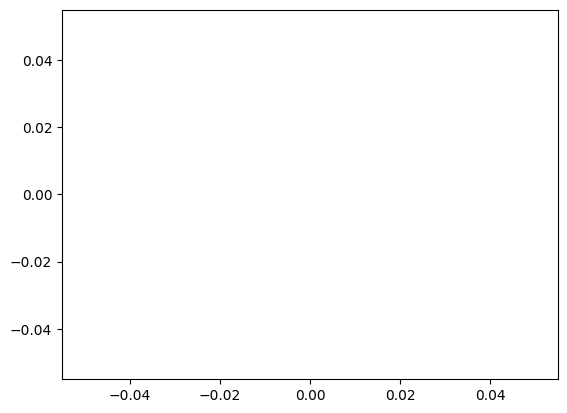

In [165]:
res['BETA'].plot()

In [151]:
df1 = res[res['ts_code']=='688981.SH'].copy()

In [159]:
df1

,ts_code,trade_date,SIZE,BETA,HSIGMA,RSTR,DASTD,CMRA,NLSIZE,BP,...,YOYProfit,YOYSales,MLEV,DTOA,BLEV,Volatility,LIQUIDITY,EARNINGS,GROWTH,LEVERAGE
399406,688981.SH,2020-07-16,17.896013,NaN,NaN,NaN,NaN,NaN,-93.453631,0.158406,...,NaN,NaN,463.297720,NaN,1.377929,NaN,NaN,NaN,NaN,NaN
399407,688981.SH,2020-07-17,17.822722,NaN,NaN,NaN,NaN,0.000000,-79.218927,0.170454,...,NaN,NaN,498.452984,NaN,1.377929,NaN,NaN,NaN,NaN,NaN
399408,688981.SH,2020-07-20,17.888092,NaN,NaN,NaN,NaN,0.027013,-86.110036,0.159668,...,NaN,NaN,466.974341,NaN,1.377929,NaN,NaN,NaN,NaN,NaN
399409,688981.SH,2020-07-21,17.881248,NaN,NaN,NaN,NaN,0.027013,-84.867093,0.160764,...,NaN,NaN,470.174470,NaN,1.377929,NaN,NaN,279.209003,NaN,NaN
399410,688981.SH,2020-07-22,17.893132,NaN,NaN,NaN,NaN,0.032053,-86.120769,0.158864,...,NaN,NaN,464.631879,NaN,1.377929,NaN,NaN,275.910568,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400656,688981.SH,2025-09-16,18.290752,NaN,NaN,0.000859,NaN,1.033822,-43.446840,0.171739,...,-0.121687,0.173407,770.285983,33.783,1.288059,NaN,0.712410,134.324440,0.02586,268.452347
400657,688981.SH,2025-09-17,18.357775,NaN,NaN,0.001058,NaN,1.033822,-52.496473,0.160606,...,-0.121687,0.173407,720.415752,33.783,1.288059,NaN,0.750919,125.616637,0.02586,251.828937
400658,688981.SH,2025-09-18,18.397523,NaN,NaN,0.001019,NaN,1.058101,-61.447950,0.154576,...,-0.121687,0.173407,692.381213,33.783,1.288059,NaN,0.793001,120.721548,0.02586,242.484091
400659,688981.SH,2025-09-19,18.390870,NaN,NaN,0.001002,NaN,1.058101,-60.553882,0.155608,...,-0.121687,0.173407,696.996499,33.783,1.288059,NaN,0.824083,121.527419,0.02586,244.022519


<Axes: >

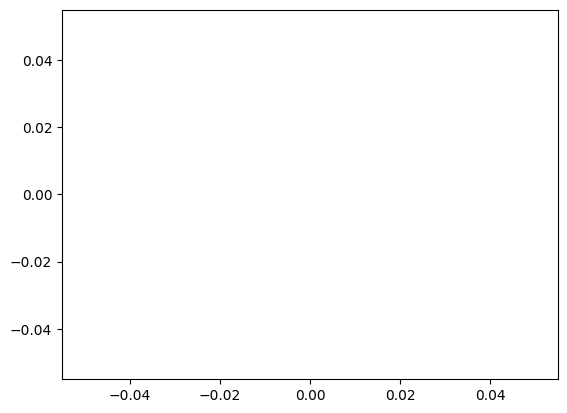

In [ ]:
df1['Volatility'